## Analysis of text displayed live on TV during the early days of the Covid-19 pandemic

This GDELT dataset containes the captured text on live TV's worldwide after every second for a period of many years. For this twist,
I decided to to select the data for sinlge day at peak time of the Covis-19 pandemic (March 2020).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import fasttext
PRETRAINED_MODEL_PATH = 'model/lid.176.bin'
lang_detector = fasttext.load_model(PRETRAINED_MODEL_PATH)

After importing some neccessary libraries we have a quick look at the dataset. Unfortunately all the 10000 rows we picked for memory issues all belong the TV station BBC. The data consist of Date colum, entities column describing some attributes of the person speaking at the moment on TV, the name of the TV program, the nummber of characters in the capture text, the TV station and most importantly the captured text. The captured text which we will analyse in this notebook is obtained using a machine learning text form video capturing model. The captured text consist of characters from multiple languages. 

In [2]:
news= pd.read_csv('gdelts-1day.csv')
news['OCRText'] = news['OCRText'].values.astype(str)

news.head(3)

,Unnamed: 0,date,entities,showName,numOCRChars,OCRText,numDistinctEntities,station
0,0,2020-02-10 00:01:00+00:00,"[{'name': 'person', 'mid': '/m/01g317', 'confi...",The Film Review,24,BBC NEWS Thailand mourns,15,BBCNEWS
1,1,2020-02-10 00:01:01+00:00,"[{'name': 'person', 'mid': '/m/01g317', 'confi...",The Film Review,24,BBC NEWS Thailand mourns,17,BBCNEWS
2,2,2020-02-10 00:00:44+00:00,"[{'name': 'person', 'mid': '/m/01g317', 'confi...",The Film Review,44,"BBC NEWS Classmate Kim Jin-mo, Best picture?",34,BBCNEWS


### Dropping all text not detected as English
The first task I performed was to use to pretrained language dection model to curated the data and drop all the rows with non english text.
This reduces the data from 10000 rows to roughly 8600 rows. Given that we only want to analysed the captured text, we create a small dataframe with on the text column of the remaining rows.

In [28]:
values = news["OCRText"].values.tolist()
langs = []

In [29]:
for val in values:
    lr, _ = lang_detector.predict(val)
    langs.append(lr[0].split("__label__")[1])

In [34]:
english = []
for i, lan in enumerate(langs):
    if lan != "en":
        print(values[i])
    else:
        english.append(values[i])

LOSCARS RED CARPET SHOW BBC NEWS Oscars 2020
THE OSCARS RED CARPET SHOW BBC NEWS Oscars 2020
ARBS BBC NEWS
111101
EEEEEEEEEE
CELEEEEEEEEE
BBC NEWS Coronavirus outbreak 原,保持出站通道畅通。
MenA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
menA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
MenA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
mencA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
menA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
menA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
menA Bank LIVE LOS ANGELES BBC NEWS Oscars 2020
ZONE NEWSDAY 00:21 BBC NEWS • INTERACTIVE
H BBC NEWS NEWSDAY 00:10
'Parasite', Curzon
'Parasite', Curzon
MANCHESTER 12BET. THE NATION LOTTER E 0OYOUNG THE NATIONAL THE NATIONAL LOTTERY
感染一科十六病区 守 G-011 BBC NEWS NEWSDAY 00:14 • INTERACTIVE
mengA Bank men LIVE LOS ANGELES NEWSDAY BBC NEWS 00:01
menA Bank men LIVE LOS ANGELES Bank NEWSDAY BBC NEWS 00:01
LIVE LOS ANGELES NEWSDAY BBC NEWS 00:01
THE AS NEWSDAY BBC NEWS 00:22 INTERACTIVE
THE A NEWSDAY BBC NEWS • INTERACTIVE 00:22
FUTUR

In [40]:
d = {'OCRText':english}
df = pd.DataFrame(data=d, index=list(range(len(english))), dtype=str)
df.head()

,OCRText
0,BBC NEWS Thailand mourns
1,BBC NEWS Thailand mourns
2,"BBC NEWS Classmate Kim Jin-mo, Best picture?"
3,"BBC NEWS Jessica, only child, Best picture?"
4,"BBC NEWS Jessica, only child, Best picture?"


First we look at a historgram of the number of characters in every sentence. Overall most captured sentences have around 100 characters and the highest number of characters in a single sentence is around 600

<AxesSubplot:>

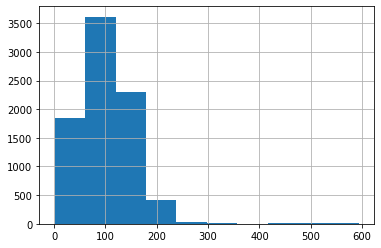

In [72]:
df['OCRText'].str.len().hist()

Next we look at a histogram of the number of words present in each sentence. On average most sentences have around 20 words and the longest sentence has up to 120 words

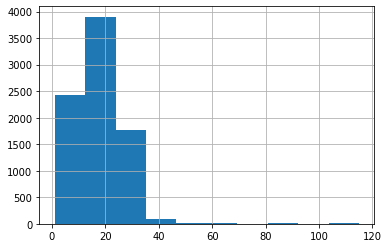

In [43]:
# Code Snippet for Word Number Histogram
# news = pd.read_csv('gdelts-1day.csv',nrows=10000, dtype={'OCRText':str})

def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).hist()

# plot_word_number_histogram(news['OCRText'])
plot_word_number_histogram(df['OCRText'])

In [12]:
!python -m nltk.downloader stopwords

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /home/ulrich/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Below we look at the distribution of all the english language stop words in our text. The word "in" has the highest frequency. This expected as for news we mostly see phrases "just live in" and alot of sentences involving "in" to adress a location.

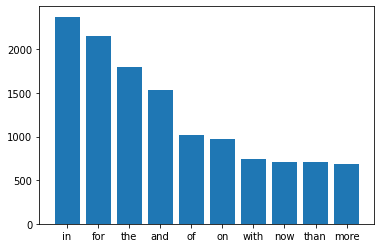

In [44]:
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)


# plot_top_stopwords_barchart(news['OCRText'])
plot_top_stopwords_barchart(df['OCRText'])

### Top n-grams of none stop words
In the next three cells we check the most popular words that appear in all the sentences. The word BBC appears alot since this part of the data mainly containes the BBC station. We also look at the top 2-grams and 3-grams. Without any suprise these aswell has the word BBC.

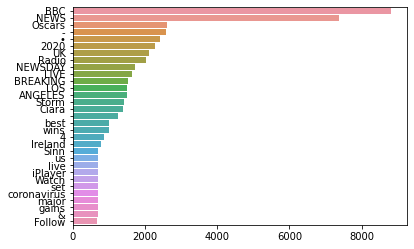

In [45]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

# plot_top_non_stopwords_barchart(news['OCRText'])
plot_top_non_stopwords_barchart(df['OCRText'])

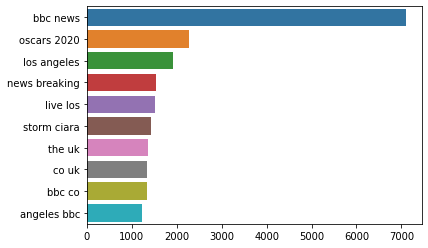

In [46]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
# plot_top_ngrams_barchart(news['headline_text'],2)
plot_top_ngrams_barchart(df['OCRText'],2)

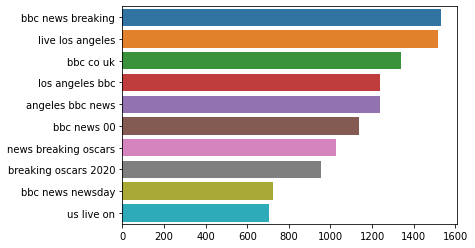

In [47]:
plot_top_ngrams_barchart(df['OCRText'],3)

In [61]:
# Code Snippet for Creating LDA visualization

import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
# import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)  # pyLDAvis.gensim
    return vis

### Topic modelling
Now we use the Latent Dirichlet Allocation (LDA) algorithm to identify different topics in the data. We look for the top 4 most relevant topics and their top-30 most relavance terms for each topic. The results are displayed interactively below using the pyLDAvis package.

In [58]:
lda_model, bow_corpus, dic = get_lda_objects(df['OCRText'])

[nltk_data] Downloading package stopwords to /home/ulrich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
lda_model.show_topics()

[(0,
  '0.069*"BBC" + 0.068*"NEWS" + 0.036*"rain" + 0.036*"90mph" + 0.036*"wind" + 0.036*"heavy" + 0.036*"lash" + 0.035*"Ciara" + 0.035*"Storm" + 0.029*"election"'),
 (1,
  '0.069*"BBC" + 0.065*"NEWS" + 0.038*"NEWSDAY" + 0.037*"BBCYourQuestions" + 0.037*"bbc.co.uk" + 0.037*"yourquestions" + 0.026*".bbc.co.uk/terms" + 0.025*"2020" + 0.024*"Oscars" + 0.019*"Coronavirus"'),
 (2,
  '0.098*"BBC" + 0.069*"NEWS" + 0.058*"Radio" + 0.036*"Oscars" + 0.035*"2020" + 0.028*"LIVE" + 0.027*"LOS" + 0.027*"ANGELES" + 0.027*"BREAKING" + 0.023*"win"'),
 (3,
  '0.039*"Oscars" + 0.037*"Storm" + 0.036*"Ciara" + 0.035*"hit" + 0.035*"disruption" + 0.035*"Air" + 0.035*"ferry" + 0.035*"passenger" + 0.035*"face" + 0.035*"rail"')]

In [62]:
plot_lda_vis(lda_model, bow_corpus, dic)

/home/ulrich/venv/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.164425  0.068154       1        1  43.482492
0     -0.323210  0.057231       2        1  21.281951
3      0.043252 -0.301292       3        1  19.682424
1      0.115533  0.175908       4        1  15.553133, topic_info=         Term         Freq        Total Category  logprob  loglift
50      Radio  2773.000000  2773.000000  Default  30.0000  30.0000
24      Storm  1624.000000  1624.000000  Default  29.0000  29.0000
22      Ciara  1608.000000  1608.000000  Default  28.0000  28.0000
28       rain   850.000000   850.000000  Default  27.0000  27.0000
21      90mph   846.000000   846.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
18        LOS   308.224939  1828.243942   Topic4  -4.0118   0.0806
15    ANGELES   308.115288  1828.168849   Topic4  -4.0122   0.0803
17       LIVE   307.388265  1918.546981   Topic4  -4.0146   0.0297
233     BRIEF   138.066534   333.509978   Topic4  -4.8149   0.9790
910  BREAKING   124.844041  1674.446646   Topic4  -4.9156  -0.7353

[212 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
173       4  0.990147      'reservation
174       1  0.017887  .bbc.co.uk/terms
174       4  0.981548  .bbc.co.uk/terms
112       4  0.992898             00:14
1008      1  0.038258             01:05
...     ...       ...               ...
195       3  0.010441             woman
195       4  0.887527             woman
257       4  0.981461              work
185       1  0.026569     yourquestions
185       4  0.972110     yourquestions

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

/home/ulrich/venv/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ulrich/venv/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ulrich/venv/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ulrich/venv/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ulrich/venv/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

In [64]:
# Code Snippet for Wordcloud

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

### Word cloud plot
This is world cloud plot to display the most popular phrases. This is indicated by the size of each phrase displayed.

[nltk_data] Downloading package stopwords to /home/ulrich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/ulrich/venv/nlp/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/ulrich/venv/nlp/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/ulrich/venv/nlp/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/ulrich/venv/nlp/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use

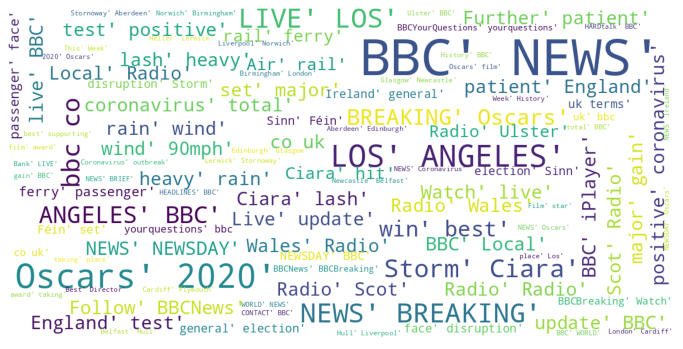

In [65]:
plot_wordcloud(df['OCRText'])

### Sentiment analysis
We perform a sentiment anlysis on the different sentences to classify the news into one of three categories (positive, negative and neutral). From the displayed historgrams below more than 90 % of the sentences are neutral. This is expected as our dataset most contain TV station phrases in most cases rather than actual news headines.

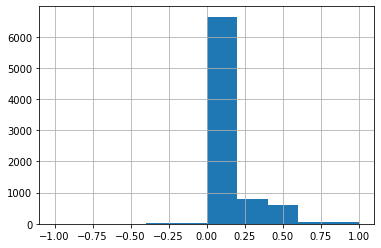

In [71]:
# Code Snippet for Polarity Histogram

from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score = text.apply(lambda x : _polarity(x))
    polarity_score.hist()

plot_polarity_histogram(df['OCRText'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ulrich/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


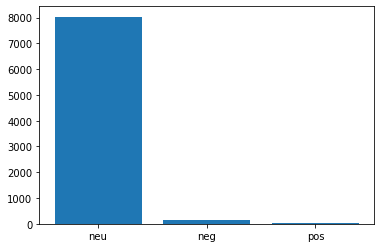

In [68]:
# Code Snippet for Sentiment Barchart

from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts())

plot_sentiment_barchart(df['OCRText'], method='Vader')

### Information to run the notebook. 
If you want to run the notebook, you need the dataset and the following packages installed

pandas, matplotlib, numpy, nltk, seaborn, sklearn, gensim, pyldavis, wordcloud, textblob, spacy, textstat

resources used https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools